## Plot the acceleration at collision points

To see if the acceleration (or deceleration) is a good enough proxy for collision where the object shape is unreliable.

In [33]:
from scripts.tools.ground_truth_toml_reader import GroundTruth
from scripts.tools.animal_dataframe import AnimalDataFrame
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scripts.tools.estimate_ground_plane import GroundPlaneEstimation
from src.loader import InstanceLoader
from src.collision import CollisionDetector

data_folder = Path("/Users/persie/PhD_Code/3d_ant_data_rle/")
session_list = [6,10,11,13,17,19,20,21,22,23,28,29,30]
obj_ref_frame = [500,180,380,849,459, 59, 842, 24, 93, 176, 2626, 595, 241 ]
prefix = "240905-1616"
skeleton_toml_path = "../skeleton.toml"

node_of_interest = ['a_L2', 'a_R2']

At the exact frame of contact, the acceleration has a mean of 0, but what if we look at the frame before or after.

In [34]:

experiment = 8
session = session_list[experiment]
obj_ref = obj_ref_frame[experiment]



In [35]:
gt = GroundTruth(data_folder, prefix, session)
track_list = gt["tracks"]


#TODO Because I'm looking when ants contact the ground, I actually only want the tracks that aren't looking at the seed.
# Load the experiment
t = InstanceLoader(data_folder=data_folder,
                   session_number=session,
                   skeleton_toml_path=skeleton_toml_path,
                   obj_ref_frame=obj_ref,
                   prefix=prefix)

#Exclude the animals that are the one track to get rid of a larger proportion of object walking


# Estimate the ground plane for this experiment
g = GroundPlaneEstimation(t.animal_list,
                          node_list=['leg_m_L2', 'leg_m_R2', 'leg_f_L2', 'leg_f_R2'])

c = CollisionDetector(animal_list=t.animal_list,
                      obj_list=[g.get_ground_collision()],
                      node_of_interest=node_of_interest)

In [36]:
window_size = range(-15, 15)
offset_array = np.full((c.n_collision, len(window_size)), np.nan)

collision_counter = 0

In [37]:

collision_tracks = c.get_tracks_in_collision()
#Find all the tracks that are in the collisions
for track in collision_tracks:

    local_collision_df = c.get_track(track)
    local_collision_frames = local_collision_df.index.unique().values

    animal = t.animal_list.animal(track)
    adf = AnimalDataFrame(animal, None, node_of_interest, signed=True)
    # acceleration_df = adf.position_xyz(clean=True).xs('z', level="Axis")
    acceleration_df = adf.displace_mag(clean=False)


    #Find the accelerations of the node in the limb
    for frame in local_collision_frames:
        for offset in window_size:
            if acceleration_df.keys().__contains__(frame+offset):
                for node in node_of_interest:
                    if node in local_collision_df.loc[frame].Limb:
                        #add acceleration at these frames to a big dataframe
                        if not np.isnan(acceleration_df[frame+offset][node]):
                            offset_array[collision_counter, int((len(window_size)/2)+offset)] = np.array(acceleration_df[frame+offset][node])
        collision_counter += 1

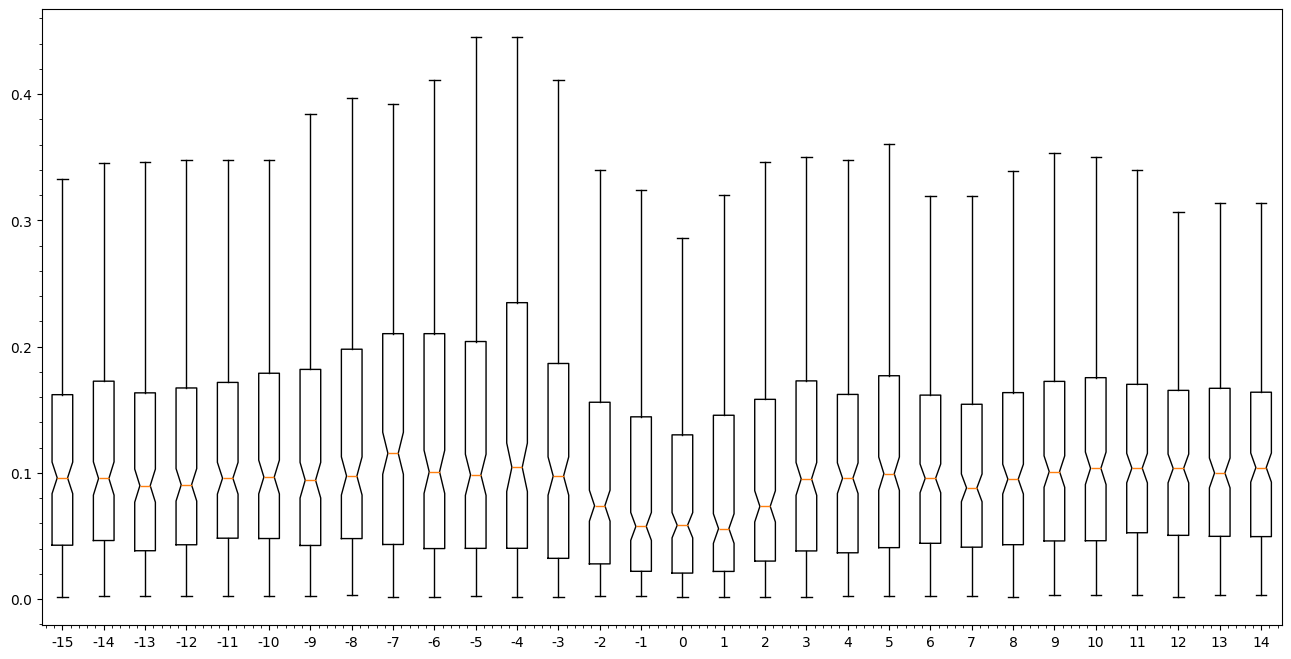

In [38]:
list_of_data = []
for col in offset_array.T:
    list_of_data.append(col[np.isfinite(col)])

fig, ax = plt.subplots(figsize=(16, 8))
ax.boxplot(list_of_data, positions=window_size, autorange=True, notch=True, showfliers=False)

# ax.plot(window_size, offset_array.T)
# ax.set_ylim(193, 196.5)

# plt.yticks(ticks=np.arange(193, 196.5, 0.1))
ax.minorticks_on()
plt.show()
